# Notebook: comparison tests
    by Ulrich Voggenberger
    16.11.2021


In [1]:
# System information
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, time, shutil
import pandas as pd
import xarray as xr
import h5py
import pickle
import netCDF4 as nc
import multiprocessing
from functools import partial
import datetime
from scipy import stats
import cdsapi
import zipfile
import warnings
warnings.filterwarnings('ignore')
from numba import njit


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab

def plt_world_map(lla,pdict = dict(var='pressure',pl='',start='1979',stop='2020',units=r'Pa'),var='_',bias='_'):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)
    
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    plt.scatter(lla[2], lla[1], s=40, alpha=1,
                c= lla[0],
                vmin=1000,
                vmax=40000,
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='cold_tropopause_point '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.title('Cold Tropopause Point ' + str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'\n'+'number of stations: '+str(len(lla[0])))

    try:
        os.mkdir('plots_new')
    except:
        pass
    #     plt.savefig('plots_new/test'), bbox_inches='tight')
    plt.show()
    plt.close()


In [3]:
def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref).values

In [4]:
def calc_anomaly(data, date, mean_preset = None):
    data_c = data.copy()
    if mean_preset == None:
        mean = [0]*12
        count = [0]*12
        for i in range(len(data_c)):
            if not np.isnan(data_c[i]):
                for j in range(1, 13):
                    if date[i].month == j:
                        mean[j-1] += data_c[i]
                        count[j-1] += 1
                        break
        for j in range(1,13):
            try:
                mean[j-1] = mean[j-1]/count[j-1]
            except:
                mean[j-1] = np.nan
    else:
        mean = mean_preset
    for i in range(len(data_c)):
        if not np.isnan(data_c[i]):
            for j in range(1,13):
                if date[i].month == j:
                    data_c[i] -= mean[j-1]
    return data_c, mean

In [5]:
def request(r_dict, dataset, data_dir = './comparison_dir', rm_files = False):
    try:
        os.makedirs(data_dir)
    except:
        pass

    tt = time.time()
    c = cdsapi.Client()
    r = c.retrieve(dataset,r_dict)
    tr = time.time()
    r.download(target='download.zip')
    tdl = time.time()
    z = zipfile.ZipFile('download.zip')
    z.extractall(path = data_dir+'/')
    z.close()
    tuz = time.time()

    print('request: ', tr - tt, ' s')
    print('download: ', tdl - tr, ' s')
    print('over all : ', tdl - tt, ' s \n-')
    print('unzip: ', tuz - tdl, ' s \n-')
    
    print('zip size: ', os.path.getsize('download.zip')/1000000., ' MB')
    filesize_token = 0
    for filename in os.listdir(data_dir):
        file_path = os.path.join(data_dir, filename)
        filesize_token += os.path.getsize('download.zip')
        if rm_files:
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))
    print('file size: ', filesize_token/1000000., ' MB')


In [6]:
import zlib
import zipfile
import requests
import urllib3

def vm_request_wrapper(request: dict,request_filename: str = None, vm_url: str = None, data_dir = './comparison_dir', rm_files = False, overwrite: bool = False):
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    if request_filename is None:
        if not 'hdf' in request:
            request_filename = '{}.zip'.format(zlib.adler32(bytes(repr(request), 'utf-8')))
        else:
            request_filename = 'out.nc'
    if not os.path.isfile(request_filename) or overwrite:
        tt = time.time()
        r = requests.post('http://early-upper-air.copernicus-climate.eu' if vm_url is None else vm_url,
                          headers={'content-type': 'application/json'},
                          json=request,
                          stream=True)
        tr = time.time()
        with open(request_filename, 'wb') as f:
            f.write(r.content)
        tdl = time.time()

    os.makedirs(data_dir, exist_ok=True)
    with zipfile.ZipFile(request_filename, 'r') as f:
        files = f.namelist()
        f.extractall(data_dir + '/')
    tuz = time.time()
    print('request: ', tr - tt, ' s')
    print('download: ', tdl - tr, ' s')
    print('over all : ', tdl - tt, ' s \n-')
    print('unzip: ', tuz - tdl, ' s \n-')

    print('zip size: ', os.path.getsize(request_filename)/1000000., ' MB')
    print(request_filename)
    filesize_token = 0
    print(data_dir)
    for filename in os.listdir(data_dir):
        file_path = os.path.join(data_dir, filename)
        filesize_token += os.path.getsize(request_filename)
    print('file size: ', filesize_token/1000000., ' MB')
    files = ["{}/{}".format(data_dir, ifile) for ifile in files]
    return files


## 1) calculation of the cold tropopause point for each station

In [32]:
sys.frozen = True
@njit(cache=True)
def ctp(obs_val, plev, date_time):
    height = 0
    counter = 0
    for i in np.unique(date_time):
        temp_data = obs_val[date_time == i]
        temp_plev = plev[date_time == i]
        found_plev = temp_plev[temp_data == np.nanmin(temp_data)]
        if len(found_plev) >= 1:
            if np.logical_not(np.isnan(found_plev[0])):
                height += found_plev[0]
                counter += 1
    if counter == 0:
        return np.nan
    else:
        return height/counter
sys.frozen = False

request:  31.031989812850952  s
download:  0.35219383239746094  s
over all :  31.384183645248413  s 
-
unzip:  0.28980207443237305  s 
-
zip size:  53.949733  MB
3797360582.zip
./comparison_dir/0
file size:  161.849199  MB


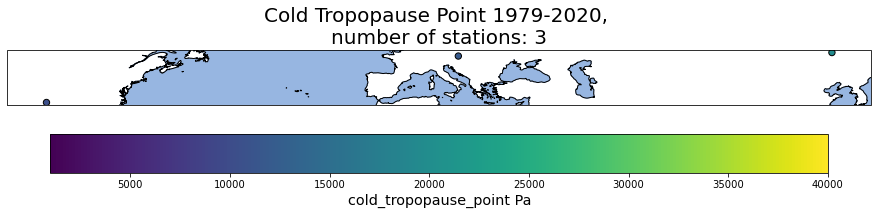

In [35]:
# request data
stat = ['11035', '72357', '50527']
rdate = ['19780101', '20201231']
file_path = './comparison_dir/0'
req =  {'variable': ["temperature"],
         'date': rdate,
         'statid': stat,
         'format': 'csv',
        }
vm_request_wrapper(req, vm_url='http://localhost:8005', data_dir = file_path, rm_files = False ,overwrite=True)

# # request data
# stat = 'all'
# rdate = ['20000101', '20000102']
# file_path = './comparison_dir/0'
# req =  {'variable': ["temperature"],
#          'date': rdate,
#          'statid': stat,
#          'format': 'csv',
#         }
# vm_request_wrapper(req, vm_url='http://localhost:8005', data_dir = file_path, rm_files = False ,overwrite=True)

# calculate ctp
ctps = []
lats = []
lons = []
for file in glob.glob(file_path+'/*.csv.gz'):
    data = pd.read_csv(file, compression='gzip')
    lats.append(float(data.latitude.iloc[0]))
    lons.append(float(data.longitude.iloc[0]))
    data = data.dropna()
    ctps.append(ctp(np.array(data.observation_value), np.array(data.z_coordinate), np.array(data.date_time)))
    
# delete downloaded files
try:
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)
except Exception as e:
    print('Failed to delete %s. Reason: %s' % (file_path, e))
    
# plot
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [12, 8]

plt_world_map([np.array(ctps), np.array(lats), np.array(lons)])

request:  2.494246482849121  s
download:  0.028142213821411133  s
over all :  2.5223886966705322  s 
-
unzip:  1.9978976249694824  s 
-
zip size:  0.953245  MB
2282429425.zip
./comparison_dir/0
file size:  666.318255  MB


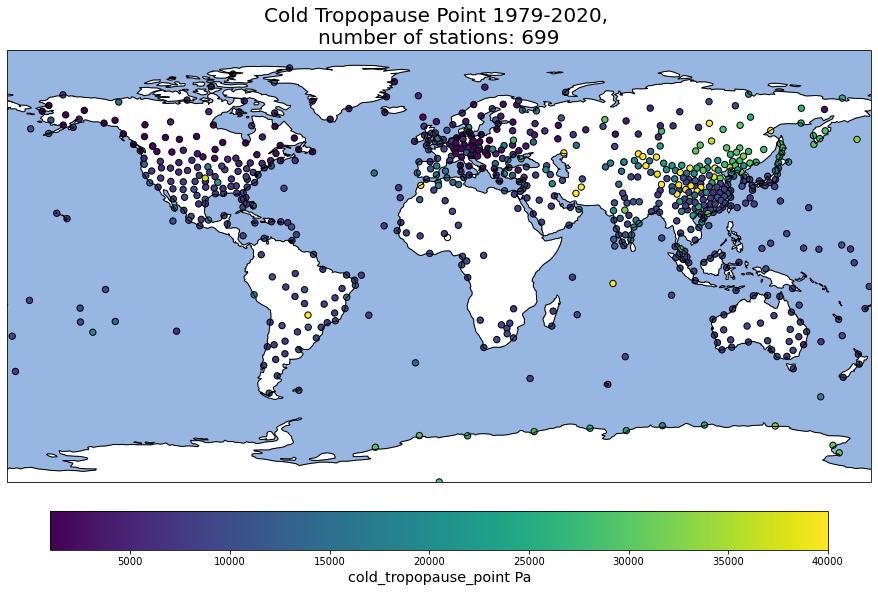

In [36]:
# request data
stat = 'all'
rdate = ['20000101', '20000102']
file_path = './comparison_dir/0'
req =  {'variable': ["temperature"],
         'date': rdate,
         'statid': stat,
         'format': 'csv',
        }
vm_request_wrapper(req, vm_url='http://localhost:8005', data_dir = file_path, rm_files = False ,overwrite=True)

# calculate ctp
ctps = []
lats = []
lons = []
for file in glob.glob(file_path+'/*.csv.gz'):
    data = pd.read_csv(file, compression='gzip')
    lats.append(float(data.latitude.iloc[0]))
    lons.append(float(data.longitude.iloc[0]))
    data = data.dropna()
    ctps.append(ctp(np.array(data.observation_value), np.array(data.z_coordinate), np.array(data.date_time)))
    
# delete downloaded files
try:
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)
except Exception as e:
    print('Failed to delete %s. Reason: %s' % (file_path, e))
    

# plot
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [12, 8]

plt_world_map([np.array(ctps), np.array(lats), np.array(lons)])

 ## 2) calculation of monthly temperature anomalies (from 1978 to 2020, at all mandatory pressure levels from 850 to 10 hPa)

### direct request

In [10]:
vm_request_wrapper({'variable': ["temperature"],
                    'date': ['19780101','20201231'],
                    'statid': '11035',
                   }, 
                   vm_url='http://localhost:8005',
                   data_dir = './comparison_dir/1',
                   rm_files = True,
                   overwrite=True)

request:  6.272837162017822  s
download:  0.2720301151275635  s
over all :  6.544867277145386  s 
-
unzip:  0.21335244178771973  s 
-
zip size:  62.341331  MB
139073208.zip
./comparison_dir/1
file size:  124.682662  MB


['./comparison_dir/1/dest_0-20001-0-11035_air_temperature.nc']

In [11]:
vm_request_wrapper({'variable': ["temperature"],
                    'date': ['19780101','20201231'],
                    'statid': '11035',
                    'format': 'csv',
                   }, 
                   vm_url='http://localhost:8005',
                   data_dir = './comparison_dir/1',
                   rm_files = True,
                   overwrite=True)

request:  24.865731239318848  s
download:  0.1382613182067871  s
over all :  25.003992557525635  s 
-
unzip:  0.13485312461853027  s 
-
zip size:  34.85825  MB
3019185103.zip
./comparison_dir/1
file size:  69.7165  MB


['./comparison_dir/1/dest_0-20001-0-11035_air_temperature.csv.gz']

In [12]:
vm_request_wrapper({'variable': ["temperature"],
                    'date': ['19780101','20201231'],
                    'statid': '11035',
                    'format': 'fast_csv',
                   }, 
                   vm_url='http://localhost:8005',
                   data_dir = './comparison_dir/1',
                   rm_files = True,
                   overwrite=True)

request:  12.070969820022583  s
download:  0.13741850852966309  s
over all :  12.208388328552246  s 
-
unzip:  0.1114201545715332  s 
-
zip size:  30.906133  MB
1170349532.zip
./comparison_dir/1
file size:  61.812266  MB


['./comparison_dir/1/dest_0-20001-0-11035_air_temperature.csv.gz']

---

In [14]:
# request({'source': 'IGRA',
#          'variable':['air_temperature'],
#          'period':'1978-01-01/2020-12-30',
#          'station_name':'AUM00011035',
#          'format':'csv',
#          'cached': 1,
#         }, 
#         'insitu-observations-igra-baseline-network',
#         data_dir = './comparison_dir/1_i',
#         rm_files = False)

In [15]:
vm_request_wrapper({'variable': ["temperature"],
                    'date': ['19780101','20201231'],
                    'statid': '11035',
                    'format': 'csv',
                   }, 
                   vm_url='http://localhost:8005',
                   data_dir = './comparison_dir/1',
                   rm_files = False,
                   overwrite=True)

request:  24.27860379219055  s
download:  0.1452484130859375  s
over all :  24.42385220527649  s 
-
unzip:  0.1216130256652832  s 
-
zip size:  34.85825  MB
3019185103.zip
./comparison_dir/1
file size:  69.7165  MB


['./comparison_dir/1/dest_0-20001-0-11035_air_temperature.csv.gz']

In [16]:
file = glob.glob('./comparison_dir/1/*.csv.gz')[0]
data = pd.read_csv(file, compression='gzip')
data = data[np.isin(data.z_coordinate, [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]
data.date_time = seconds_to_datetime(data.date_time)

In [17]:
data

,latitude,longitude,date_time,z_coordinate,report_id,observation_value,station_name
0,48.250000,16.370001,1978-01-01 00:00:00,1000.0,20000027730,207.500000,WIEN/HOHE WARTE (11035-1)
1,48.250000,16.370001,1978-01-01 00:00:00,2000.0,20000027730,208.899994,WIEN/HOHE WARTE (11035-1)
2,48.250000,16.370001,1978-01-01 00:00:00,3000.0,20000027730,208.500000,WIEN/HOHE WARTE (11035-1)
3,48.250000,16.370001,1978-01-01 00:00:00,5000.0,20000027730,205.699997,WIEN/HOHE WARTE (11035-1)
5,48.250000,16.370001,1978-01-01 00:00:00,7000.0,20000027730,214.100006,WIEN/HOHE WARTE (11035-1)
...,...,...,...,...,...,...,...
5797870,48.248951,16.357180,2020-12-31 11:30:10,30000.0,nnnnnnnnnnn,NaN,WIEN/HOHE WARTE (11035-1)
5798183,48.248951,16.357180,2020-12-31 11:30:10,40000.0,nnnnnnnnnnn,NaN,WIEN/HOHE WARTE (11035-1)
5798452,48.248951,16.357180,2020-12-31 11:30:10,50000.0,nnnnnnnnnnn,NaN,WIEN/HOHE WARTE (11035-1)
5798881,48.248951,16.357180,2020-12-31 11:30:10,70000.0,nnnnnnnnnnn,NaN,WIEN/HOHE WARTE (11035-1)


In [18]:
data.dropna()

,latitude,longitude,date_time,z_coordinate,report_id,observation_value,station_name
0,48.250000,16.370001,1978-01-01 00:00:00,1000.0,20000027730,207.500000,WIEN/HOHE WARTE (11035-1)
1,48.250000,16.370001,1978-01-01 00:00:00,2000.0,20000027730,208.899994,WIEN/HOHE WARTE (11035-1)
2,48.250000,16.370001,1978-01-01 00:00:00,3000.0,20000027730,208.500000,WIEN/HOHE WARTE (11035-1)
3,48.250000,16.370001,1978-01-01 00:00:00,5000.0,20000027730,205.699997,WIEN/HOHE WARTE (11035-1)
5,48.250000,16.370001,1978-01-01 00:00:00,7000.0,20000027730,214.100006,WIEN/HOHE WARTE (11035-1)
...,...,...,...,...,...,...,...
2808231,48.248951,16.357180,2019-09-30 23:30:11,30000.0,10000055084,233.979996,WIEN/HOHE WARTE (11035-1)
2808236,48.248951,16.357180,2019-09-30 23:30:11,40000.0,10000055084,249.809998,WIEN/HOHE WARTE (11035-1)
2808240,48.248951,16.357180,2019-09-30 23:30:11,50000.0,10000055084,261.149994,WIEN/HOHE WARTE (11035-1)
2808249,48.248951,16.357180,2019-09-30 23:30:11,70000.0,10000055084,274.390015,WIEN/HOHE WARTE (11035-1)


In [19]:
anomalies = {}
for i in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]:
    temp_data = data[data.z_coordinate == i].reset_index()
    anomalies[str(i)] = calc_anomaly(temp_data.observation_value, temp_data.date_time)

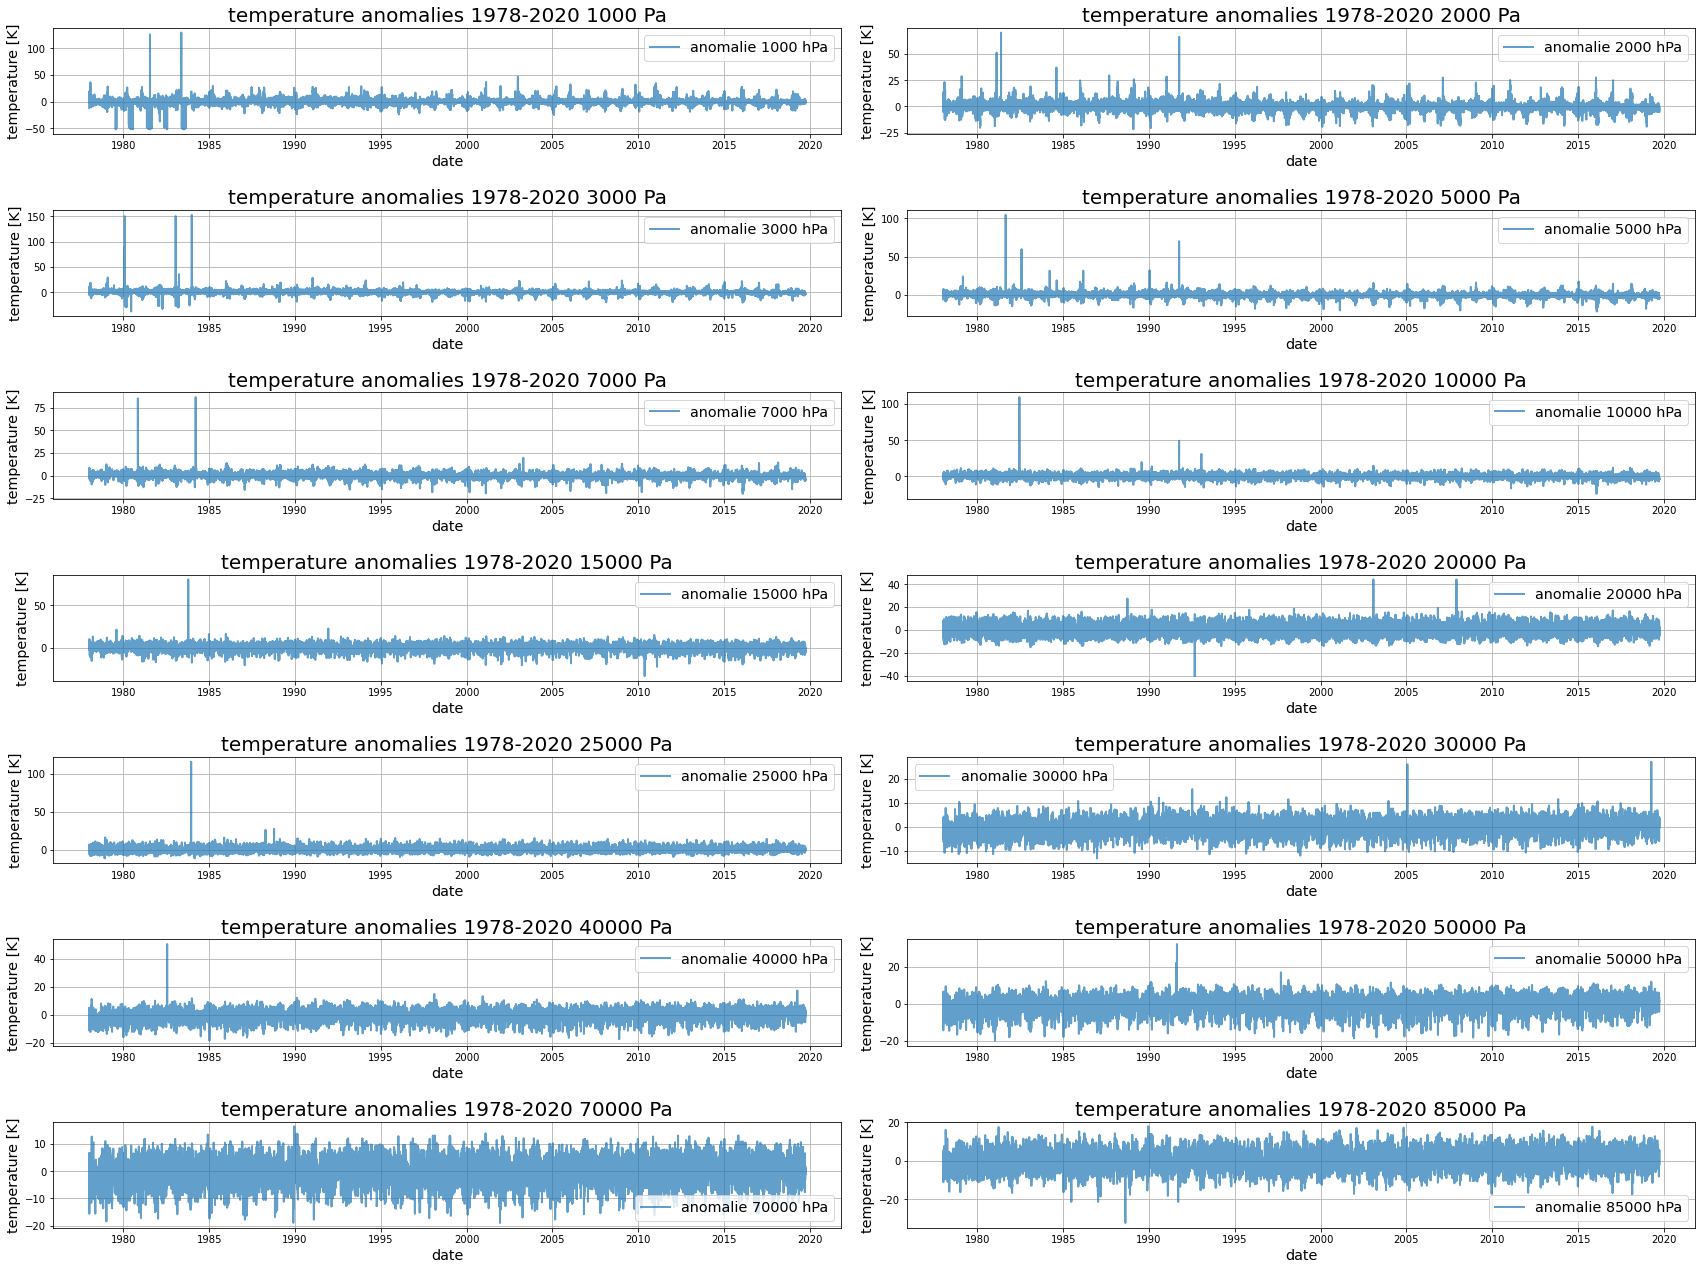

In [20]:
plt.rcParams['figure.figsize'] = [24, 18]
fig, axs = plt.subplots(7, 2)
axs = axs.ravel()
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]
for i in range(len(plevs)):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='temperature [K]', title='temperature anomalies 1978-2020 '+ str(plevs[i])+' Pa')
    anoms = anomalies[str(plevs[i])][0]
    axs[i].plot(data[data.z_coordinate == plevs[i]].date_time, anoms , label='anomalie '+str(plevs[i])+' hPa', linewidth=2, alpha=0.7)
    axs[i].legend()
fig.tight_layout(pad=2.0)
plt.show()

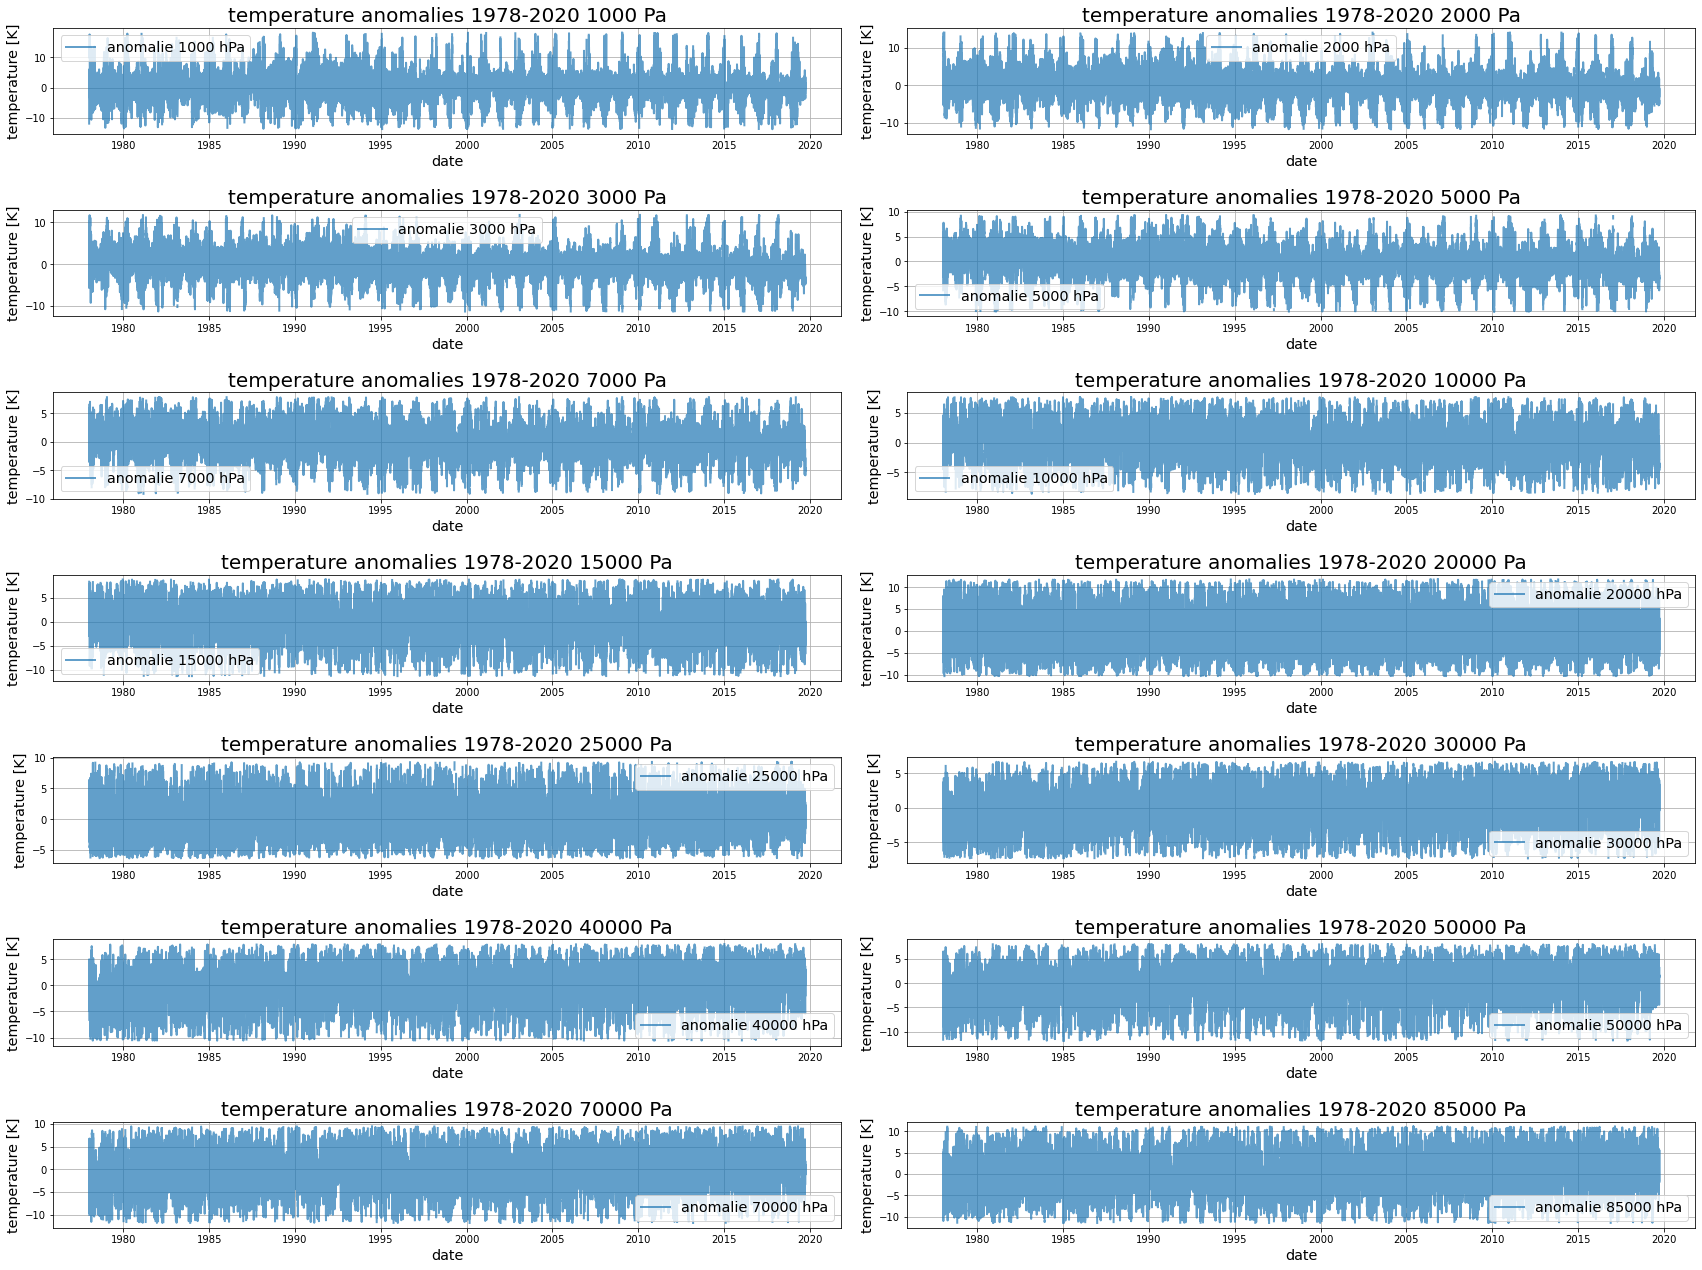

In [21]:
plt.rcParams['figure.figsize'] = [24, 18]
fig, axs = plt.subplots(7, 2)
axs = axs.ravel()
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]
for i in range(len(plevs)):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='temperature [K]', title='temperature anomalies 1978-2020 '+ str(plevs[i])+' Pa')
    anoms = anomalies[str(plevs[i])][0]
    anoms[anoms > np.nanquantile(anoms, 0.99)] = np.nan
    anoms[anoms < np.nanquantile(anoms, 0.01)] = np.nan
    axs[i].plot(data[data.z_coordinate == plevs[i]].date_time, anoms , label='anomalie '+str(plevs[i])+' hPa', linewidth=2, alpha=0.7)
    axs[i].legend()
fig.tight_layout(pad=2.0)
plt.show()

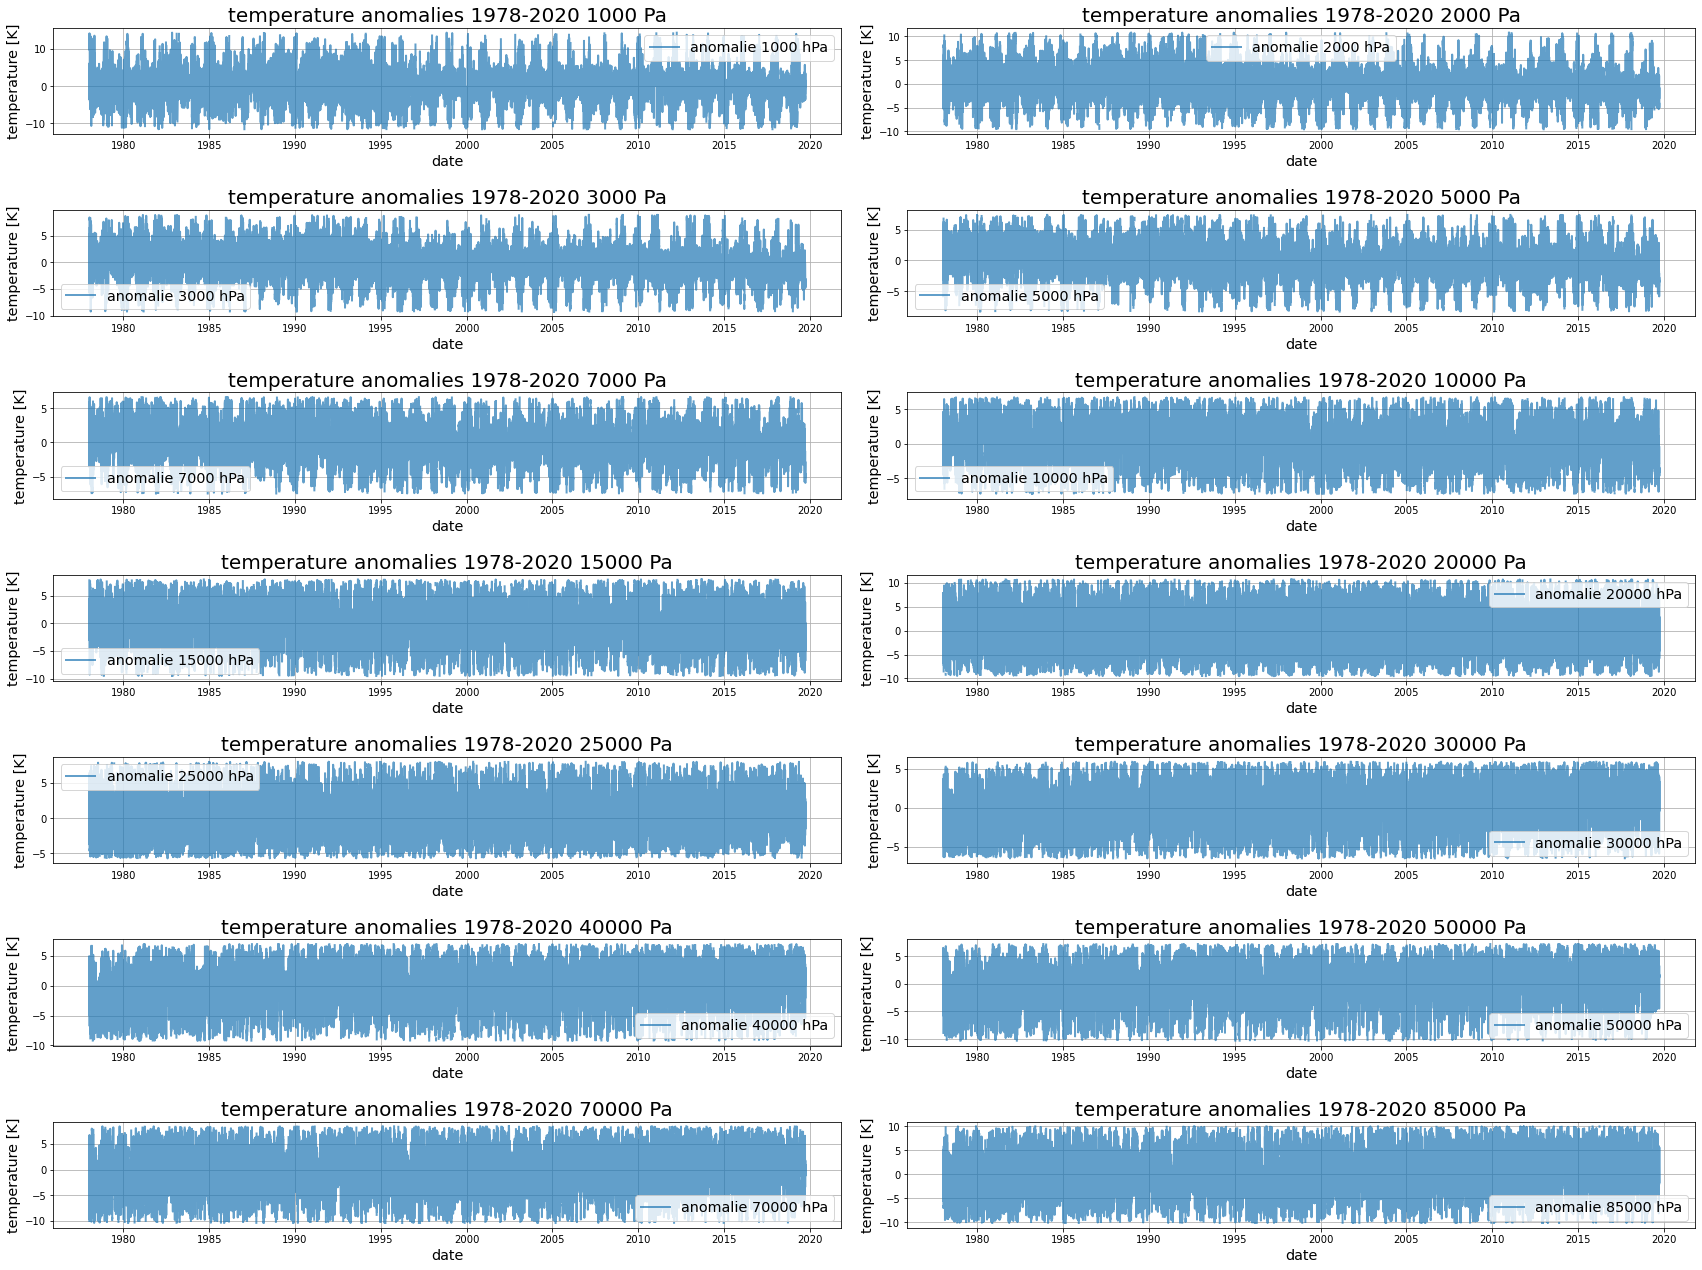

In [22]:
plt.rcParams['figure.figsize'] = [24, 18]
fig, axs = plt.subplots(7, 2)
axs = axs.ravel()
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]
for i in range(len(plevs)):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='temperature [K]', title='temperature anomalies 1978-2020 '+ str(plevs[i])+' Pa')
    anoms = anomalies[str(plevs[i])][0]
    anoms[anoms > np.nanquantile(anoms, 0.99)] = np.nan
    anoms[anoms < np.nanquantile(anoms, 0.01)] = np.nan
    axs[i].plot(data[data.z_coordinate == plevs[i]].date_time, anoms , label='anomalie '+str(plevs[i])+' hPa', linewidth=2, alpha=0.7)
    axs[i].legend()
fig.tight_layout(pad=2.0)
plt.show()

## 3) simulation of a request coming from the CDS form by setting as filters a geographic area (defining a bounding box with the latitude and longitude ranges) and a time range on a monthly basis

In [23]:
vm_request_wrapper({'variable': ["temperature"],
                    'date': ['19780101','20201231'],
                    'area': [50,15,45,20], #[lat_max, lon_min, lat_min, lon_max] <-> [N, W, S, E] - same sequence like in the CDS form
                    'format': 'csv',
                   }, 
                   vm_url='http://localhost:8005',
                   data_dir = './comparison_dir/2',
                   rm_files = False,
                   overwrite=True)

request:  78.91581273078918  s
download:  0.9694299697875977  s
over all :  79.88524270057678  s 
-
unzip:  1.0138492584228516  s 
-
zip size:  238.612598  MB
1570577609.zip
./comparison_dir/2
file size:  5726.702352  MB


['./comparison_dir/2/dest_0-20000-0-11858_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11855_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11880_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11903_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11918_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11927_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-12600_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-12812_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-12822_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11240_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-14021_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-14240_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-14253_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-14370_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11171_air_temperature.csv.